# Carga de datos

In [1]:
#Descarga
!wget -c http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

Using TensorFlow backend.


In [ ]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [ ]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

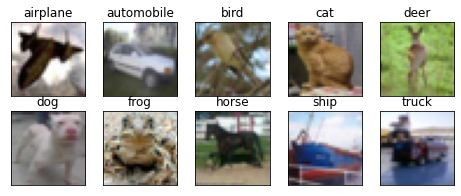

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
print(tr_signs[0].shape)
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

# Utilidades
En esta sección se ejecutan todas las funciones que contienen las utilidades que se emplearán en la fase de experimentación

## Dibujo de gráficas
La primera función sirve para dibujar las gráficas con el historial de entrenamiento

In [4]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1,step=len(model_history.history['accuracy'])/10))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1,step=len(model_history.history['loss'])/10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Creación de modelos
A continuación se definen las funciones necesarias para la creación de los modelos que se utilizarán en la experimentación.

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import experimental

def build_model_v1(dout=True, bn=True):
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(32, 32, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(128))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(128))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('softmax'))
    return model

def build_model_v2(dout=True, bn=True):
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(32, 32, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(128))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(32))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('softmax'))
    return model

def build_model_v3(dout=True, bn=True):
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(32, 32, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(1024))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(512))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('softmax'))
    return model


def create_block(block_input, n_filtros, bn, bn_before):
    x = block_input
    for i in range(2):
        x = Conv2D(n_filtros, kernel_size=(3,3), padding="same")(x)
        if bn and bn_before:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        if bn and not bn_before:
            x = BatchNormalization()(x)
    return x

def build_conv1(dout=True, bn=True, bn_before=True, extra_layer=False): # De https://www.kaggle.com/mahtabshaan/autoencoder-as-feature-extractor-cifar10
    net_input = Input((32,32,3))
    x = net_input
    #x = experimental.preprocessing.Rescaling(1./255)(x)
    #x = experimental.preprocessing.RandomRotation(0.2)(x)
    #x = experimental.preprocessing.RandomZoom(.2)(x)
    #x = experimental.preprocessing.RandomFlip("horizontal")(x)

    block1 = create_block(x, 32, bn, bn_before)
    x = MaxPooling2D(pool_size=(2, 2))(block1)
    if dout:
        x = Dropout(0.2)(x)

    block2 = create_block(x, 64, bn, bn_before)
    x = MaxPooling2D(pool_size=(2, 2))(block2)
    if dout:
        x = Dropout(0.3)(x)

    block3 = create_block(x, 128, bn, bn_before)
    x = MaxPooling2D(pool_size=(2, 2))(block3)
    if dout:
        x = Dropout(0.3)(x)

    x = Flatten()(x)
    if extra_layer:
        x = Dense(2048)(x)
    output = Dense(43, activation='softmax')(x)
    return Model(net_input, output)

def initializer():
    return RandomUniform(minval=-0.05, maxval=0.05, seed=None)

def build_conv2(dout=True):
    cnn = Sequential()
    cnn.add(Convolution2D(100, (7, 7), padding="same", input_shape=(224, 224, 3), activation='relu', bias_initializer=initializer()))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Convolution2D(150, (4, 4), padding="same", bias_initializer=initializer()))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Convolution2D(250, (4, 4), padding="same", bias_initializer=initializer()))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu', bias_initializer=initializer()))
    if dout:
        cnn.add(Dropout(0.5))
    cnn.add(Dense(43, activation='softmax', bias_initializer=initializer()))

# Experimentación
## Modelo ffNN 1
### Incluyendo capas de dropout y batch normalization

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

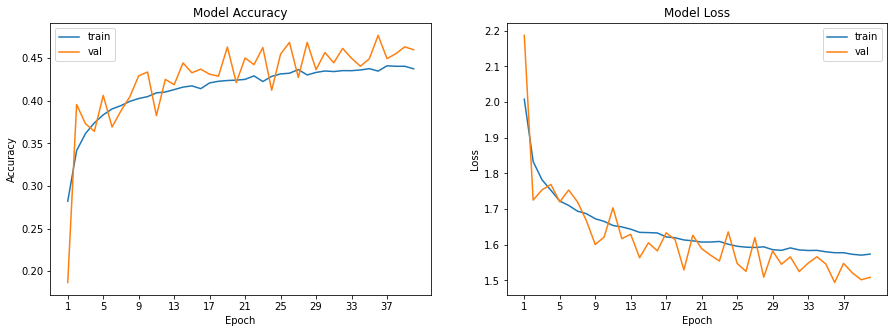

Training MLP took 184.56765842437744 seconds


In [6]:
model = build_model_v1()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Con capa de dropout pero sin batch normalization

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               393344    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

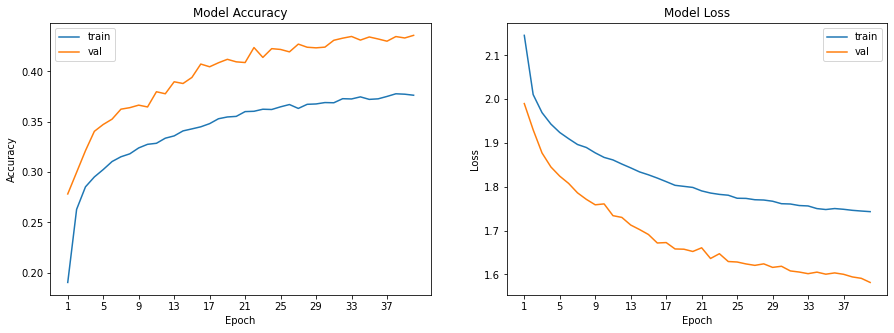

Training MLP took 167.4495804309845 seconds


In [7]:
model = build_model_v1(bn=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Con capa de batch normalization pero sin dropout

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               393344    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)              

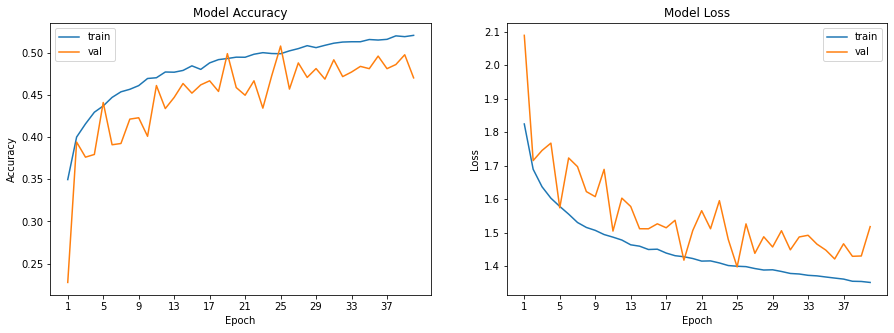

Training MLP took 173.5159637928009 seconds


In [8]:
model = build_model_v1(dout=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

## Modelo ffNN 2
### Incluyendo capas de dropout y batch normalization

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_3 (RandomZoom)   (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               393344    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)              

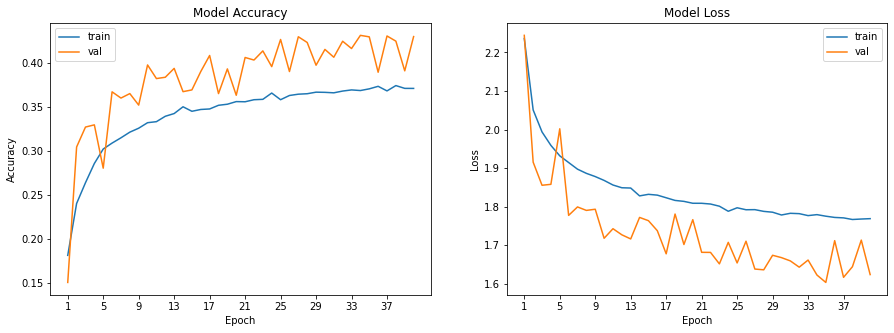

Training MLP took 187.76963686943054 seconds


In [9]:
model = build_model_v2()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Incluyendo capas de dropout, pero sin batch normalization

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_4 (RandomZoom)   (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               393344    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

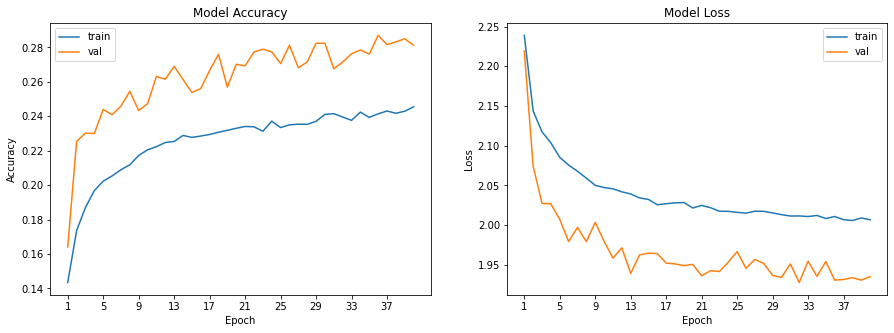

Training MLP took 178.80553483963013 seconds


In [10]:
model = build_model_v2(bn=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Incluyendo capas de batch normalization, pero sin dropout

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_5 (RandomZoom)   (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               393344    
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)              

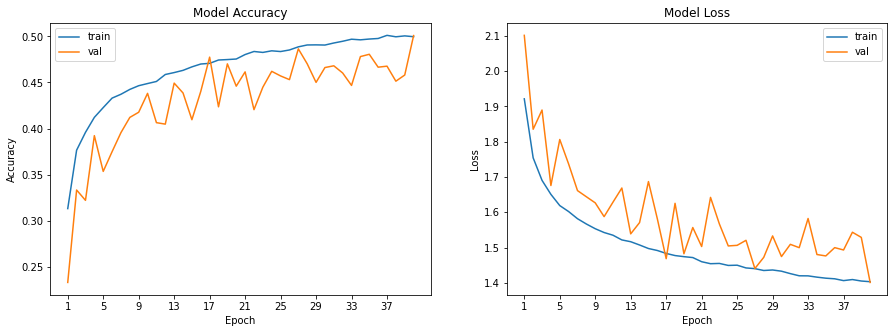

Training MLP took 178.42547297477722 seconds


In [11]:
model = build_model_v2(dout=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

## Modelo ffNN 3
### Incluyendo capas de dropout y batch normalization

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_6 (RandomRot (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_6 (RandomZoom)   (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_6 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
batch_normalization_13 (Batc (None, 1024)             

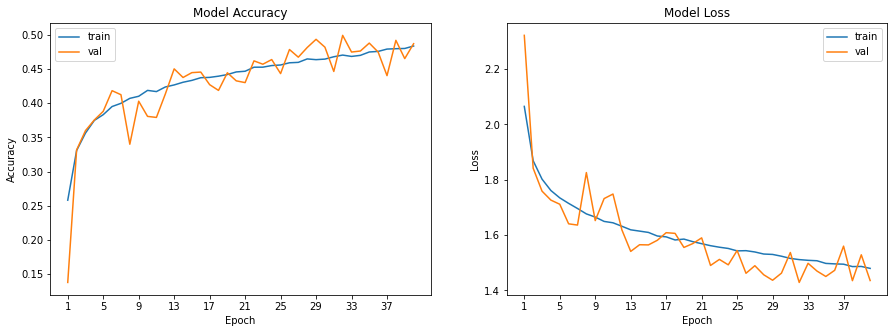

Training MLP took 474.6749999523163 seconds


In [12]:
model = build_model_v3()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Incluyendo capas de dropout, pero sin batch normalization

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_8 (RandomRot (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_8 (RandomZoom)   (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_8 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)             

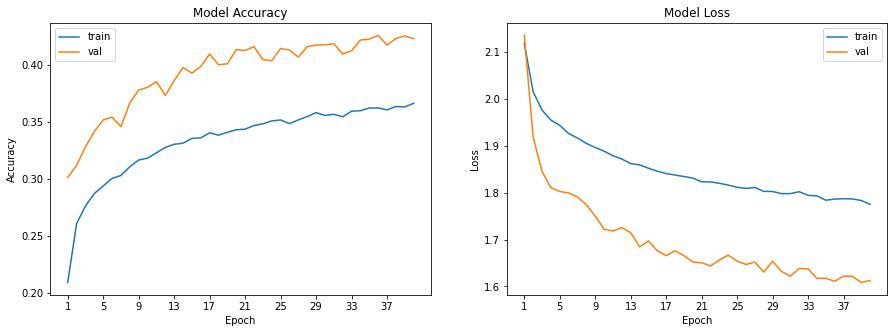

Training MLP took 441.5425057411194 seconds


In [15]:
model = build_model_v3(bn=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Incluyendo capas de batch normalization, pero sin dropout

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_9 (RandomRot (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_9 (RandomZoom)   (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_9 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
batch_normalization_22 (Batc (None, 1024)             

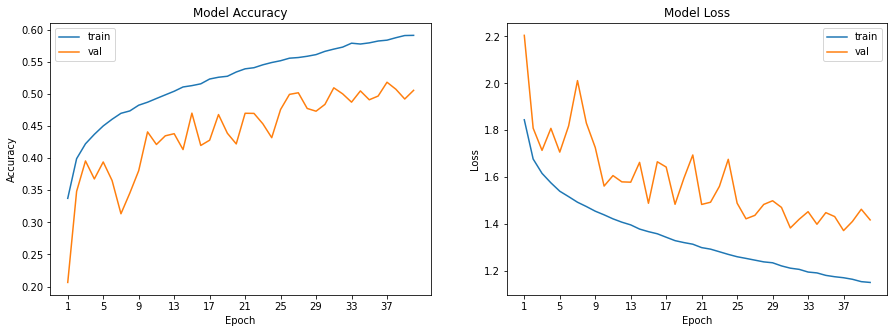

Training MLP took 420.7865135669708 seconds


In [16]:
model = build_model_v3(dout=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

## Red convolucional 1
En la experimentación con la red neuronal hay muchas variables que afectan al desempeño:
- Incluir capa de dropout o no
- Incluir capa de batch normalization antes o despues de la de activación, o simplemente no inlcuirla
- Incluir una capa extra o no.
Para no perder eficiencia del modelo se comprobó su desempeño con casi todas las combinaciones de configuraciones posibles (se excluyeron aquellas en las que no hay capa de dropout ni capa de batch normalization). Para entender en cada sección de esta experimentación que configuración tiene el modelo entrenado se incluye en el titulo de la sección los valores que toman cada una de las 3 variables mencionadas.

### dropput=si, batch_normalization=despues, capa_extra=no

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling_10 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_10 (RandomRo (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_10 (RandomZoom)  (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_10 (RandomFlip)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 32)        128   

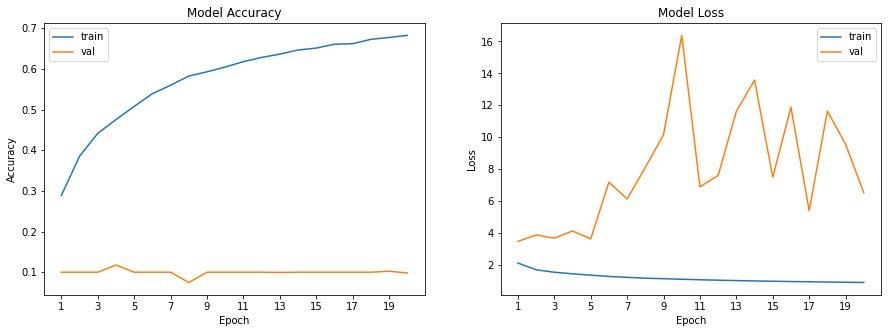

Training MLP took 3595.912137031555 seconds


In [27]:
import keras.backend as K
import time

model = build_conv1(dout=True, bn=True, bn_before=True, extra_layer=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=si, batch_normalization=antes, capa_extra=no

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling_11 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_11 (RandomRo (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_11 (RandomZoom)  (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_11 (RandomFlip)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_50 (Activation)   (None, 32, 32, 32)        0   

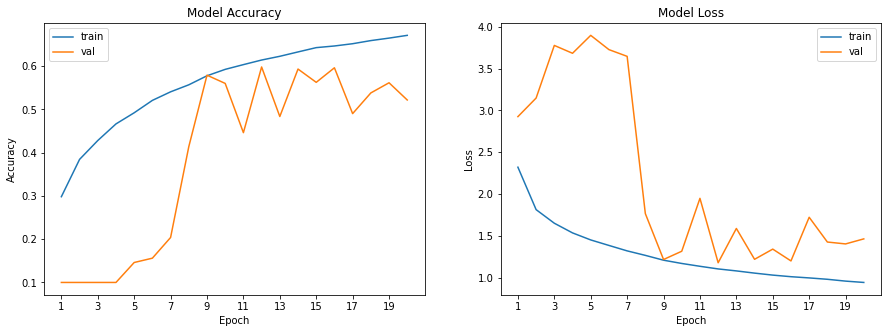

Training MLP took 3954.2219698429108 seconds


In [28]:
model = build_conv1(dout=True, bn=True, bn_before=False, extra_layer=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=si, batch_normalization=no, capa_extra=no

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling_12 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_12 (RandomRo (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_12 (RandomZoom)  (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_12 (RandomFlip)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_56 (Activation)   (None, 32, 32, 32)        0   

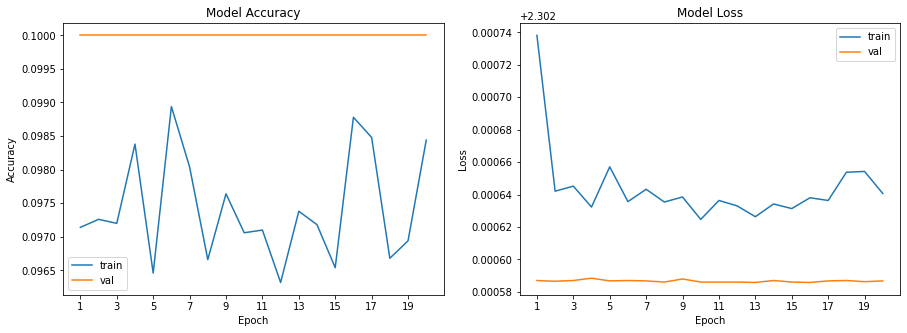

Training MLP took 2091.79728102684 seconds


In [29]:
model = build_conv1(dout=True, bn=False, extra_layer=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=no, batch_normalization=despues, capa_extra=no

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling_13 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_13 (RandomRo (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_13 (RandomZoom)  (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_13 (RandomFlip)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_38 (Batc (None, 32, 32, 32)        128 

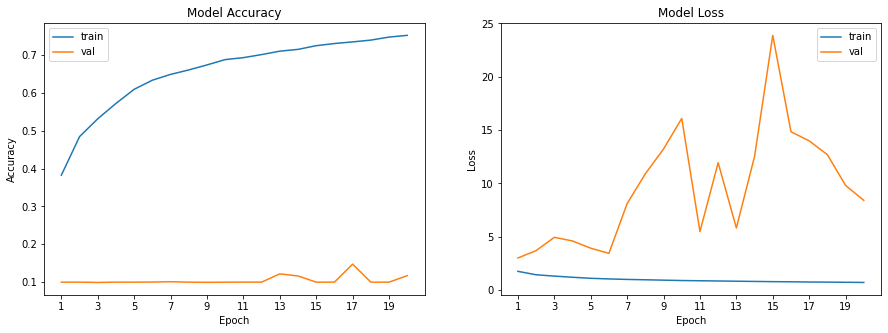

Training MLP took 4458.491060256958 seconds


In [30]:
model = build_conv1(dout=False, bn=True, bn_before=True, extra_layer=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=no, batch_normalization=antes, capa_extra=no

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling_14 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_14 (RandomRo (None, 32, 32, 3)         0         
_________________________________________________________________
random_zoom_14 (RandomZoom)  (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip_14 (RandomFlip)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_68 (Activation)   (None, 32, 32, 32)        0   

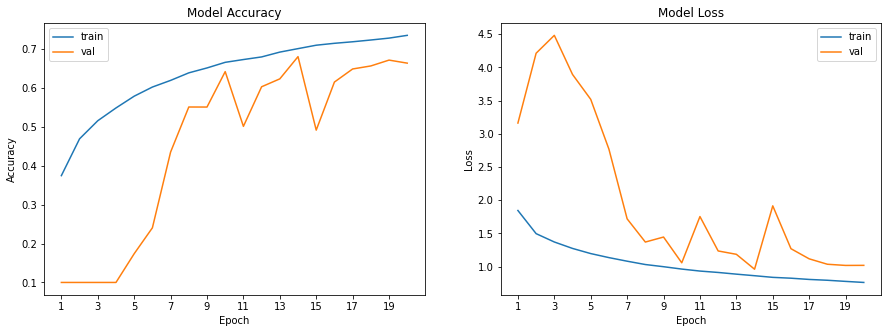

Training MLP took 3594.7169919013977 seconds


In [31]:
model = build_conv1(dout=False, bn=True, bn_before=False, extra_layer=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=si, batch_normalization=despues, capa_extra=si

In [37]:
model = build_conv1(dout=True, bn=True, bn_before=True, extra_layer=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

TypeError: Inputs to a layer should be tensors. Got: <tensorflow.python.keras.layers.core.Dense object at 0x000001E1AD644EC8>

### dropput=si, batch_normalization=antes, capa_extra=si

In [ ]:
model = build_conv1(dout=True, bn=True, bn_before=False, extra_layer=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=si, batch_normalization=no, capa_extra=si


In [ ]:
model = build_conv1(dout=True, bn=False, extra_layer=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=no, batch_normalization=despues, capa_extra=si

In [ ]:
model = build_conv1(dout=False, bn=True, bn_before=True, extra_layer=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=no, batch_normalization=antes, capa_extra=si

In [ ]:
model = build_conv1(dout=False, bn=True, bn_before=False, extra_layer=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

## Red convolucional 2
Esta red esta tomada del articulo "Multi-column deep neural network for traffic sign classification" de Ciresan et al. (2012)

### Con dropout

In [ ]:
model = build_conv2(dout=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Sin dropout

In [ ]:
model = build_conv2(dout=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")